# <center> <img src="../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> **Big Data** </center>
---
### <center> **Autumn 2025** </center>
---
### <center> **Examples on Structured Streaming (Kafka)** </center>
---
**Date**: nov, 2025
**Profesor**: Pablo Camarillo Ramirez
**Student Name**: Carlos Eduardo Chihenseck Blanco

**Introduction**
Objective
To build a data pipeline in Python using Apache Spark for data consumption in continuous mode, transformation, and persistence, with the objective of addressing a practical problem. 

En este proyecto se busca mostrar la construccion, desarrollo y uso de un pipeline de "structured streaming" conel uso de spark y kafka


**Problema**

En esta ocasion, tome de inspiracion el dataset dela otra entrega, ya que se me hizo una buena idea que se hiciera en structured streaming, para de esa manera estar monitoreando los terremotos y en el momento que sucedan se pueda mejorar el pipeline con regression lineal para predecir si se pudiera generar un tsunami en base a los datos recogidos anteriormente

docker exec -it bc4f8a808a4d9980e14501f8d0161b8d8d449812a77aff344d750277b2d64e94 /opt/kafka/bin/kafka-topics.sh --create --topic topic_finalproject2 --bootstrap-server localhost:9093 

python3 producer.py kafka:9093 topic_finalproject2

# Create SparkSession
## Install Kafka connector

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on Structured Streaming (Kafka)") \
    .master("spark://spark-master:7077") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.13:4.0.0") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("INFO")

# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")

:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /root/.ivy2.5.2/cache
The jars for the packages stored in: /root/.ivy2.5.2/jars
org.apache.spark#spark-sql-kafka-0-10_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-3cb4e356-4746-44c8-a30d-6f197636dc6a;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.13;4.0.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.13;4.0.0 in central
	found org.apache.kafka#kafka-clients;3.9.0 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.7 in central
	found org.slf4j#slf4j-api;2.0.16 in central
	found org.apache.hadoop#hadoop-client-runtime;3.4.1 in central
	found org.apache.hadoop#hadoop-client-api;3.4.1 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.scala-lang.modules#scala-parallel-collections_2.13;1.2.0

# Create a data stream from a Kafka topic

In [2]:
# Create the remote connection
kafka_df = spark.readStream \
            .format("kafka") \
            .option("kafka.bootstrap.servers", "kafka:9093") \
            .option("subscribe", "topic_finalproject2") \
            .option("maxOffsetsPerTrigger", "500")\
            .load()

kafka_df.printSchema()




root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



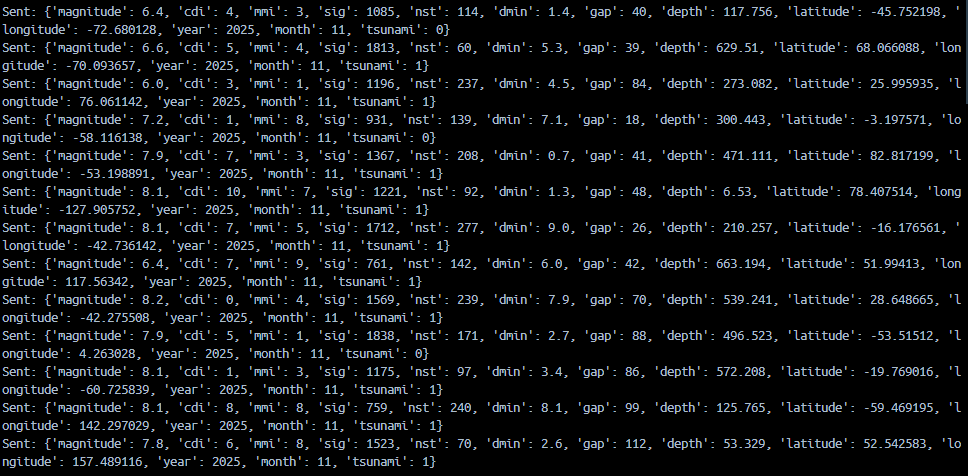

**Consumer**

In [13]:
from carlosedochb.spark_utils import SparkUtils
from pyspark.sql.functions import col

review_df=kafka_df.select(kafka_df.value.cast("string").alias("value"))

route="/opt/spark/work-dir/data/logs"

logs_schema = SparkUtils.generate_schema([("magnitude", "float"),
                  ("cdi", "int"),
                  ("mmi", "int"),
                  ("sig", "int"),
                  ("nst", "int"),
                  ("dmin", "float"),
                  ("gap", "float"),
                  ("depth", "float"),
                  ("latitude", "float"),
                  ("longitude", "float"),
                  ("year", "int"),
                  ("month", "int"),
                  ("tsunami","int")])

In [4]:
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
review_df.printSchema()

review_extracted_df = review_df.withColumn("review", from_json(col("value"), logs_schema))
review_extracted_df.printSchema()

root
 |-- value: string (nullable = true)

root
 |-- value: string (nullable = true)
 |-- review: struct (nullable = true)
 |    |-- magnitude: float (nullable = true)
 |    |-- cdi: integer (nullable = true)
 |    |-- mmi: integer (nullable = true)
 |    |-- sig: integer (nullable = true)
 |    |-- nst: integer (nullable = true)
 |    |-- dmin: float (nullable = true)
 |    |-- gap: float (nullable = true)
 |    |-- depth: float (nullable = true)
 |    |-- latitude: float (nullable = true)
 |    |-- longitude: float (nullable = true)
 |    |-- year: integer (nullable = true)
 |    |-- month: integer (nullable = true)
 |    |-- tsunami: integer (nullable = true)



**Tansformations**

In [10]:
from pyspark.sql.functions import col, round, when


tsunami_df = review_extracted_df.select("review.*")
tsunami_df=tsunami_df.dropna()
tsunami_df = tsunami_df \
    .withColumn("gap", col("gap").cast("int")) \
    .withColumn("magnitude", (round(col("magnitude") * 2) / 2)) \
    .withColumn("dmin", round(col("dmin"), 1))\
    .withColumn("year", col("year").cast("string"))\
    .withColumn("magnitude", col("magnitude").cast("string"))\
    .withColumn("depth", col("depth").cast("string"))\
    .withColumn(
    "month",
    when(col("month") == 1, "January")
    .when(col("month") == 2, "February")
    .when(col("month") == 3, "March")
    .when(col("month") == 4, "April")
    .when(col("month") == 5, "May")
    .when(col("month") == 6, "June")
    .when(col("month") == 7, "July")
    .when(col("month") == 8, "August")
    .when(col("month") == 9, "September")
    .when(col("month") == 10, "October")
    .when(col("month") == 11, "November")
    .when(col("month") == 12, "December")
)

tsunami_df.printSchema()

root
 |-- magnitude: string (nullable = true)
 |-- cdi: integer (nullable = true)
 |-- mmi: integer (nullable = true)
 |-- sig: integer (nullable = true)
 |-- nst: integer (nullable = true)
 |-- dmin: float (nullable = true)
 |-- gap: integer (nullable = true)
 |-- depth: string (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- tsunami: integer (nullable = true)



**Persistance**

In [12]:
import time
query_files = tsunami_df.writeStream\
    .outputMode("append") \
    .trigger(processingTime="10 seconds") \
    .format("csv") \
    .partitionBy("month")\
    .option("header", "true")\
    .option("path", "/opt/spark/work-dir/data/tsunami_output/") \
    .option("checkpointLocation", "/opt/spark/work-dir/tsunami_checkpoint") \
    .start()
time.sleep(60)
query_files.stop()

25/11/22 23:22:44 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
25/11/22 23:23:44 WARN DAGScheduler: Failed to cancel job group 281e8ba1-519d-4f65-bedb-995b1fa1c319. Cannot find active jobs for it.
25/11/22 23:23:44 WARN DAGScheduler: Failed to cancel job group 281e8ba1-519d-4f65-bedb-995b1fa1c319. Cannot find active jobs for it.


In [16]:
!pwd
!ls ../data/tsunami_output

/opt/spark/work-dir/examples
'month=11'
 part-00000-022aa9e2-1d5c-4955-bf98-c4a5f62738da-c000.csv
 part-00000-030a362e-4bfd-4b9f-a063-5bfa674037f0-c000.csv
 part-00000-078ef0ef-cb1a-4946-bcfa-84ec9301ffed-c000.csv
 part-00000-0bf9d7a3-75c9-4204-825d-b7a1c545dedd-c000.csv
 part-00000-1193d709-ff0f-41eb-bf31-8cca1c1926ed-c000.csv
 part-00000-1cb7f99f-6baa-4bd2-9ce2-8c65ea0f1111-c000.csv
 part-00000-27e7e210-5142-4f9b-a25a-12d2a95b4e62-c000.csv
 part-00000-302dc80e-e450-4393-9cc9-0ac6fcfa462b-c000.csv
 part-00000-35833f22-e7aa-472e-a52a-a3378e6ce702-c000.csv
 part-00000-38677bad-74a2-48ce-9735-2b0ce91893fc-c000.csv
 part-00000-4287f493-ac25-4ec4-b8ce-d53d47946fdc-c000.csv
 part-00000-5318efd2-5dc3-47c1-9895-274009e6bf86-c000.csv
 part-00000-53a89267-aeef-4e7d-9dc0-6a2d369314c5-c000.csv
 part-00000-547950be-2a22-44fa-a3c4-7e65550f8393-c000.csv
 part-00000-5f2e5752-ccaf-4175-a615-3e7eb97b473c-c000.snappy.parquet
 part-00000-609bd581-26d2-482b-b393-7ce319b620f7-c000.csv
 part-00000-62ddec41-

In [17]:

sc.stop()

**Power BI Dashboard**

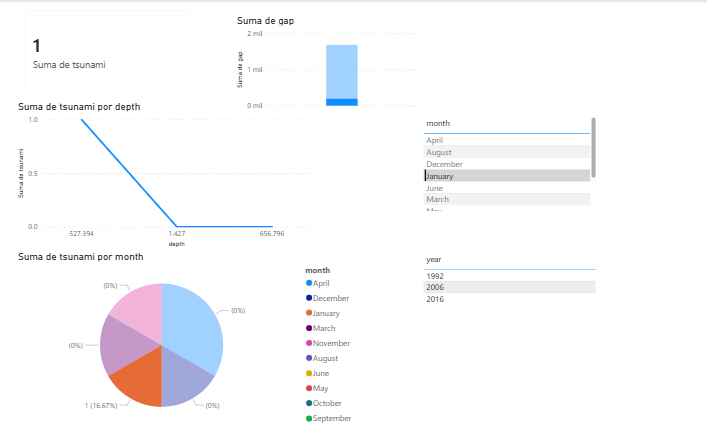